# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [68]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [69]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [70]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [71]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [72]:
class buildTrain():
    def __init__(self, X, y, perc=0.8, std=False, pca=0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        assert n_data == len(y)
        
        dopca = pca is None or pca > 0
        
        #check and remove nan values
        temp = X.copy()
        temp[y.name] = y.copy()
        temp.dropna(axis=0, how='any', inplace=True)
        
        if temp.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (X.shape[0], X.shape[1]+1, *temp.shape))
            X = temp
            y = temp[y.name]
            X.drop(y.name, axis=1, inplace=True)
            n_data, _ = X.shape
    
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        train_mask = perm < perc
        valid_mask = ~ train_mask
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        assert (len(train_data)+len(valid_data)) == n_data
        
        if std:
            mean = train_data.mean(axis=0)
            std = train_data.std(axis=0) + 1e-10
            train_data = (train_data - mean) / std
            valid_data = (valid_data - mean) / std
            print('Performed standardization')
        
        if dopca:
            my_pca = PCA(n_components=pca)
            my_pca.fit(train_data)
            train_data = my_pca.transform(train_data)
            valid_data = my_pca.transform(valid_data)
            print('performed PCA, number of features: %d, explained variance for component:\n'%(my_pca.n_components_), 
                  ['%.2f'%i for i in my_pca.explained_variance_ratio_])
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv
    
    def get_size(self):
        return self.Xt.shape[0], self.Xv.shape[0]

In [73]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [74]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [75]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [76]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [77]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [130]:
class interface():
    def __init__(self, seed = None, build_seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        self.build_seed = build_seed
            
    def train(self, X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=30, **args):
        np.random.seed(self.seed)
        self._check_balanced(y, threshold_unbalanced, args)
        _,_, valid = self._train(X, y, percentage, std, pca, epochs, args)
        if self.unbalanced:
            self._unbal_output(valid)
        self.train_param = (X, y, percentage, std, pca, epochs, args)
            
    def _check_balanced(self, y, threshold_unbalanced, args):
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat] 
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if 'class_weight' in args and args['class_weight'] is None:
                class_weight = {cat: 1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                args['class_weight'] = class_weight
                print('Weights used:', {i:float('%.2f'%class_weight[i]) for i in class_weight})
            unbalanced = True
        self.unbalanced = unbalanced
        
    def _train(self, X, y, percentage, std, pca, epochs, args):
        raise Exception('not implemented')
            
    def _unbal_output(self, valid):
        Xv, yv = valid
        obj = self.obj
        d_cat = {}
        for i in yv:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
        mask = yv != max_cat
        if np.sum(mask) == 0:
            raise Exception('No data in smaller part of valid set')
        minority_score = obj.score(Xv[mask], yv[mask])
        majority_score = obj.score(Xv[~mask], yv[~mask])
        print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(mask)/len(yv)*100, minority_score))
        print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(~mask)/len(yv)*100, majority_score))
        print('Category histogram in validation set:', d_cat)
            
   
        
    def test(self, n=10):
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            tscores, vscores,_ = self._train(self.train_param)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y, fill_up=False):
        obj = self.obj
        assert y.shape[0] == X.shape[0]
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert to_be_predicted.shape[0] != 0
        prediction = obj.predict(to_be_predicted)
        if fill_up:
            y[mask] = prediction
        return prediction

In [131]:
def train_perc_warm(perc, X, y, epochs, eta0, percentage, f_eta, std, pca, v, build_seed):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    n_features = data.get_train()[0].shape[1]
    n_classes = len(data.get_train()[1].unique())
    
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores, data.get_valid()

In [132]:
def train_perc_cold(perc, X, y, percentage, max_iter, std, pca, build_seed):
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore, data.get_valid()

In [133]:
class perc(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):
        warm_start = True
        learning_rate = args.get('learning_rate', 'optimal')
        it_interval = args.pop('it_interval', 100)
        power_t = args.get('power_t', 0.5)
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')                
            
        #compute max_iter
        max_iter = epochs * it_interval
        args['max_iter'] = it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(**args)

        param_warm = (perc_, X, y, epochs, args['eta0'], percentage, f_eta, std, pca, True, self.build_seed)
        param_cold = (perc_, X, y, percentage, max_iter, std, pca, self.build_seed)
        
        #perform analysis
        if warm_start:
            tscores, vscores, valid = train_perc_warm(*param_warm)
        else:
            tscores, vscores, valid = train_perc_cold(*param_cold)
            
        self.obj = perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'Perceptron interface'

In [134]:
def train_MLP(ml_perc, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    tscores = []
    vscores = []
    for epoch in range(max_iter):
        ml_perc.set_params(max_iter=epoch+1)
        ml_perc.fit(*data.get_train())
        tscore = ml_perc.score(*data.get_train())
        vscore = ml_perc.score(*data.get_valid())
        loss = ml_perc.loss_
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        ml_perc.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [135]:
class MLP(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):             
            
        #create multiple perceptron
        ml_perc_ = MLPClassifier(**args)
        
        param_warm = (ml_perc_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_MLP(*param_warm)
        
        #save settings
        self.obj = ml_perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'MLP interface'

In [136]:
def train_LR(log_reg, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        log_reg.set_params(max_iter=epoch+1)
        log_reg.fit(*data.get_train())
        tscore = log_reg.score(*data.get_train())
        vscore = log_reg.score(*data.get_valid())
        if v:
            print(f"epoch={epoch} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        log_reg.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [137]:
class LogReg(interface):
    
    #penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
    #verbose=0, warm_start=False, n_jobs=1
    #solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
    #default: ‘liblinear’ Algorithm to use in the optimization problem.
    #For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    #For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
    #handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
    
    #Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem 
    #is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution. 
    #Does not work for liblinear solver.

         
    def _train(self, X, y, percentage, std, pca, epochs, args):            
        
        #create logistic regression
        log_regr_ = LogisticRegression(**args)
        
        param_warm = (log_regr_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_LR(*param_warm)
        
        #save settings
        self.obj = log_regr_
        return tscores, vscores, valid
    def __str__(self):
        return 'Logistic Regression interface'

In [138]:
def test_sup(X, y, *objs):
    assert X.shape[0] == len(y)
    scores = np.zeros(len(objs))
    c = 0
    plt.figure()
    for obj in objs:
        if not isinstance(obj, interface):
            raise Exception('must pass interface subclass object')
        print(X.shape, y.shape)
        score = obj.obj.score(X, y)
        print(score)
        scores[c] = score
        print(scores)
        c += 1
        print(c)
        plt.plot(c, score, '.', label=str(obj))
    legend = plt.legend(loc=(1.01, 0), shadow=True)
    plt.show()
    i_max = np.argmax(scores)
    print('best is %s with score %.2f' % (str(objs[i_max]), scores[i_max]))

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we optimize parameters in unbalanced dataset? Because for us we can go over 50% on big and small dataset
4. What can we do if dataset unbalanced and we are using MLP?

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Tests

### K-means on traffic
Just an exploratory study, let's see what we get...

In [ ]:
from sklearn.cluster import KMeans

X = df_clean[traffic_columns]
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X)
score = check_clusters(y=y, clust_labels=km.labels_)

now we try the same but with standardized columns, see the difference

In [ ]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X_std)
score = check_clusters(y=y, clust_labels=km.labels_)

It seems to have improved. Still the clusters seem to separate pretty poorly. Let's see the optimal value of k based on our previous score (using standardized data which seem to make more sense). We set the same seed each time so that the results are comparable and not influenced by different initial centroid allocation.

In [ ]:
my_test = test()

np.random.seed(23453)
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, n_jobs=4)
    km.fit(X_std)
    
    score= check_clusters(y=y, clust_labels=km.labels_, v=False)
    my_test.update(score, k)
        
my_test.get_result()

### Hierarchical clustering on traffic data
Same approach as for k-means, test difference between standardized and not.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

try complete linkage

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

### Perceptron (imputation of age data with traffic data)

First of all we try to build a Perceptron to complete the age column keeping all the categories.

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['NumericAge'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
print(dict_numage_to_agecat)
df["NumericAge"] = df["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df[traffic_columns]
y = df['NumericAge']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
my_perc.predict(X,y)

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['Urban'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
X = df[traffic_columns]
#unbalanced?
#np.bincount(y[~np.isnan(y)].astype(int))
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None))

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]

y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
print(y.unique())
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

### MLP

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_MLP = MLP()

In [ ]:
my_MLP.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-1, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
             alpha = 0.0, tol = -1)

In [ ]:
my_MLP.predict(X,y)

In [ ]:
a = df_clean['OS_clean'].copy()
d = dict()
for i in a:
    d[i] = d.get(i, 0) + 1
d

# Logistic Regression

In [20]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_lr = LogReg()

Performed standardization
performed PCA, number of features: 13, explained variance for component:
 ['0.13', '0.10', '0.10', '0.08', '0.08', '0.08', '0.08', '0.07', '0.07', '0.07', '0.07', '0.06', '0.00']
epoch=0 tscore=0.6464560204953032 vscore=0.6014234875444839
epoch=1 tscore=0.6660973526900086 vscore=0.6120996441281139


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increas

epoch=2 tscore=0.7284372331340735 vscore=0.701067615658363
epoch=3 tscore=0.7386848847139197 vscore=0.708185053380783
epoch=4 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=5 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=6 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=7 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=8 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=9 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=10 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=11 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=12 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=13 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=14 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=15 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=16 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=17 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=18 tscore=0.7378309137489325 vscore=0.7081

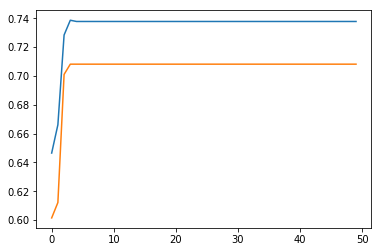

In [21]:
my_lr.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

## Data imputation taken seriously
### OS

In [88]:
df_filled = df_clean.copy()

X = df_filled[traffic_columns]
y = df_filled['OS_clean']
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 456245
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1226, test size 226


run=1 tscore=0.451515 vscore=0.462745
run=2 tscore=0.451515 vscore=0.470588
run=3 tscore=0.448485 vscore=0.494118
run=4 tscore=0.454545 vscore=0.513725
run=5 tscore=0.455556 vscore=0.513725
run=6 tscore=0.461616 vscore=0.509804
run=7 tscore=0.460606 vscore=0.505882
run=8 tscore=0.460606 vscore=0.505882
run=9 tscore=0.467677 vscore=0.505882
run=10 tscore=0.470707 vscore=0.505882
run=11 tscore=0.469697 vscore=0.513725
run=12 tscore=0.478788 vscore=0.529412
run=13 tscore=0.488889 vscore=0.537255
run=14 tscore=0.49697 vscore=0.552941
run=15 tscore=0.49798 vscore=0.560784
run=16 tscore=0.49697 vscore=0.568627
run=17 tscore=0.507071 vscore=0.564706
run=18 tscore=0.513131 vscore=0.564706
run=19 tscore=0.515152 vscore=0.564706
run=20 tscore=0.522222 vscore=0.560784
run=21 tscore=0.519192 vscore=0.564706
run=22 tscore=0.522222 vscore=0.576471
run=23 tscore=0.517172 vscore=0.580392
run=24 tscore=0.517172 vscore=0.580392
run=25 tscore=0.522222 vscore=0.568627
run=26 tscore=0.531313 vscore=0.56470

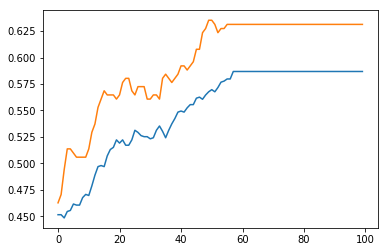

In [30]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=0.8427020617208935 tscore=0.5898989898989899 vscore=0.6352941176470588
epoch=1 loss=0.7669189831325941 tscore=0.5888888888888889 vscore=0.6352941176470588
epoch=2 loss=0.7546294913381016 tscore=0.5959595959595959 vscore=0.6509803921568628
epoch=3 loss=0.7341612212682227 tscore=0.6444444444444445 vscore=0.6705882352941176
epoch=4 loss=0.7189154892170758 tscore=0.6313131313131313 vscore=0.6549019607843137
epoch=5 loss=0.7093320451012805 tscore=0.6393939393939394 vscore=0.6588235294117647
epoch=6 loss=0.6971940438499804 tscore=0.6545454545454545 vscore=0.7019607843137254
epoch=7 loss=0.6900426062838051 tscore=0.7626262626262627 vscore=0.8
epoch=8 loss=0.6855102491921644 tscore=0.6636363636363637 vscore=0.7058823529411765
epoch=9 loss=0.6653613261152931 tscore=0.7232323232323232 vscore=0.7686274509803922
epoch=10 loss=0.6615174305576824 tscore=0.7272727272727273 vscore=0.7803921568627451
epoch=11 loss=0.6727469919517298 tscore=0.7161616161616161 vscore=0.7450980392156863
epoch

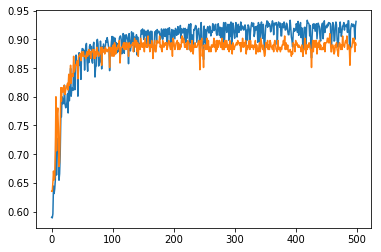

In [31]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

epoch=0 tscore=0.5868686868686869 vscore=0.6313725490196078
epoch=1 tscore=0.5868686868686869 vscore=0.6313725490196078
epoch=2 tscore=0.6080808080808081 vscore=0.6431372549019608


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=3 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=4 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=5 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=6 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=7 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=8 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=9 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=10 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=11 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=12 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=13 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=14 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=15 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=16 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=17 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=18 tscore=0.6070707070707071 vscore=0.6431372549019608
epoch=19 tscore=0.6070707070707

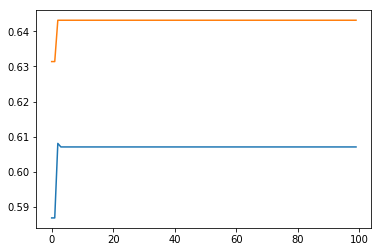

In [32]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(207, 13) (207,)
0.5845410628019324
[0.58454106 0.         0.        ]
1
(207, 13) (207,)
0.855072463768116
[0.58454106 0.85507246 0.        ]
2
(207, 13) (207,)
0.5603864734299517
[0.58454106 0.85507246 0.56038647]
3


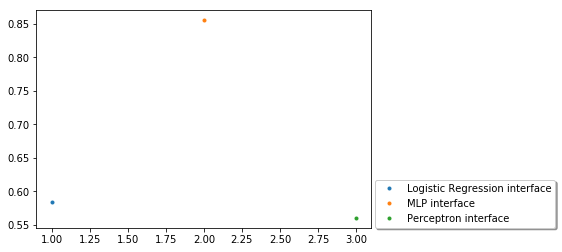

best is MLP interface with score 0.86


In [33]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

Therefore we use this MLP to predict the rest of the column OS and keep the predictions to imput into our dataset later.

In [34]:
os_missing = my_MLP.predict(X,y, fill_up=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 33 columns):
ID                                2000 non-null int64
Product                           2000 non-null object
CustomerAge                       1880 non-null object
DataAllowance                     1636 non-null float64
DataArpu                          1493 non-null float64
DeviceFlag4G                      2000 non-null float64
DeviceFlagSmartphone              2000 non-null float64
MonthlyDataTraffic                1917 non-null float64
MonthlyVoiceTrafficCount          1917 non-null float64
CustomerGender                    2000 non-null float64
CustomerImmigrant                 2000 non-null float64
DevicePrice                       752 non-null float64
MonthlySmsTrafficCount            1999 non-null float64
Province                          1575 non-null object
Region                            1575 non-null object
ZipCode                           1654 non-null object
Devic

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Urbanization

In [35]:
X = df_filled[traffic_columns]
y = df_filled['Urban'].map(lambda x: int(x), na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1426, test size 228


run=1 tscore=0.230292 vscore=0.242424
run=2 tscore=0.230292 vscore=0.242424
run=3 tscore=0.230292 vscore=0.242424
run=4 tscore=0.233835 vscore=0.239057
run=5 tscore=0.248893 vscore=0.23569
run=6 tscore=0.26395 vscore=0.245791
run=7 tscore=0.28698 vscore=0.289562
run=8 tscore=0.31178 vscore=0.306397
run=9 tscore=0.360496 vscore=0.3367
run=10 tscore=0.40744 vscore=0.407407
run=11 tscore=0.428698 vscore=0.410774
run=12 tscore=0.434012 vscore=0.410774
run=13 tscore=0.434898 vscore=0.410774
run=14 tscore=0.43667 vscore=0.410774
run=15 tscore=0.43667 vscore=0.410774
run=16 tscore=0.43667 vscore=0.410774
run=17 tscore=0.43667 vscore=0.410774
run=18 tscore=0.43667 vscore=0.410774
run=19 tscore=0.435784 vscore=0.410774
run=20 tscore=0.435784 vscore=0.410774
run=21 tscore=0.435784 vscore=0.410774
run=22 tscore=0.435784 vscore=0.410774
run=23 tscore=0.435784 vscore=0.410774
run=24 tscore=0.435784 vscore=0.410774
run=25 tscore=0.435784 vscore=0.410774
run=26 tscore=0.435784 vscore=0.410774
run=27 

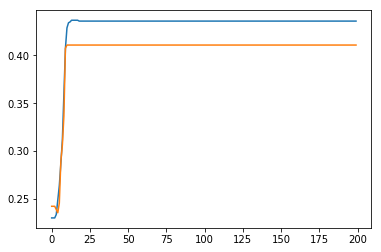

In [36]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=200,  loss='squared_hinge', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.1327932678454984 tscore=0.43135518157661645 vscore=0.4074074074074074
epoch=1 loss=1.124664739894445 tscore=0.43401240035429584 vscore=0.4107744107744108
epoch=2 loss=1.1178504608698512 tscore=0.4366696191319752 vscore=0.4107744107744108
epoch=3 loss=1.1123550922598577 tscore=0.4357838795394154 vscore=0.4107744107744108
epoch=4 loss=1.10750005559125 tscore=0.4366696191319752 vscore=0.4107744107744108
epoch=5 loss=1.1039478405878052 tscore=0.4357838795394154 vscore=0.4107744107744108
epoch=6 loss=1.1005235674337017 tscore=0.4357838795394154 vscore=0.4107744107744108
epoch=7 loss=1.0979750226648624 tscore=0.4357838795394154 vscore=0.4107744107744108
epoch=8 loss=1.095657063947464 tscore=0.4357838795394154 vscore=0.4107744107744108
epoch=9 loss=1.0936770819877828 tscore=0.4357838795394154 vscore=0.4107744107744108
epoch=10 loss=1.0920601089003539 tscore=0.4357838795394154 vscore=0.4107744107744108
epoch=11 loss=1.090695507022352 tscore=0.4357838795394154 vscore=0.4107744107

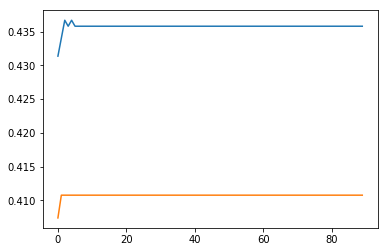

In [37]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=90,
             hidden_layer_sizes = (200,), batch_size = 50, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.10, tol = 1e-4)

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=0 tscore=0.4357838795394154 vscore=0.4107744107744108
epoch=1 tscore=0.43312666076173606 vscore=0.4074074074074074
epoch=2 tscore=0.4366696191319752 vscore=0.4107744107744108
epoch=3 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=4 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=5 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=6 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=7 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=8 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=9 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=10 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=11 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=12 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=13 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=14 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=15 tscore=0.43932683790965454 vscore=0.4107744107744108
epoch=16 tscore=0.43

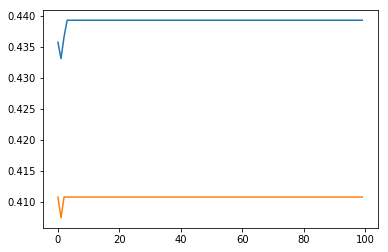

In [38]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(228, 13) (228,)
0.4692982456140351
[0.46929825 0.         0.        ]
1
(228, 13) (228,)
0.4605263157894737
[0.46929825 0.46052632 0.        ]
2
(228, 13) (228,)
0.4605263157894737
[0.46929825 0.46052632 0.46052632]
3


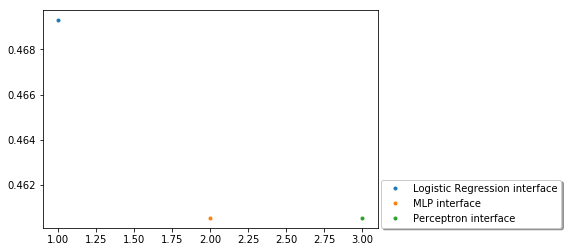

best is Logistic Regression interface with score 0.47


In [39]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

In [ ]:
urbanization = my_MLP.predict(X,y, fill_up=True)

# Numeric Age

In [139]:
df_filled = df_clean.copy()

dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
df_filled["NumericAge"] = df_filled["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df_filled[traffic_columns]
y = df_filled['NumericAge']
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 456222
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1586, test size 294


Weights used: {1.0: 1.55, 0.0: 2.86, 2.0: 226.57}
run=1 tscore=0.655118 vscore=0.607595
run=2 tscore=0.655118 vscore=0.607595
run=3 tscore=0.655118 vscore=0.607595
run=4 tscore=0.653543 vscore=0.60443
run=5 tscore=0.653543 vscore=0.601266
run=6 tscore=0.650394 vscore=0.60443
run=7 tscore=0.651969 vscore=0.610759
run=8 tscore=0.647244 vscore=0.613924
run=9 tscore=0.646457 vscore=0.610759
run=10 tscore=0.647244 vscore=0.613924
run=11 tscore=0.648031 vscore=0.60443
run=12 tscore=0.646457 vscore=0.607595
run=13 tscore=0.648819 vscore=0.607595
run=14 tscore=0.648819 vscore=0.610759
run=15 tscore=0.648031 vscore=0.607595
run=16 tscore=0.647244 vscore=0.607595
run=17 tscore=0.648819 vscore=0.607595
run=18 tscore=0.648819 vscore=0.610759
run=19 tscore=0.644882 vscore=0.610759
run=20 tscore=0.644882 vscore=0.610759
run=21 tscore=0.645669 vscore=0.610759
run=22 tscore=0.647244 vscore=0.610759
run=23 tscore=0.644882 vscore=0.610759
run=24 tscore=0.644882 vscore=0.613924
run=25 tscore=0.644882 vsc

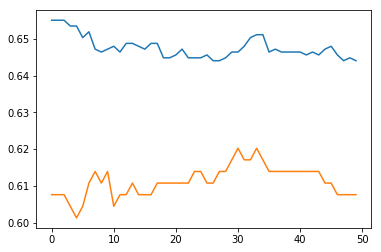

In [140]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', 
              eta0=1e-4, class_weight=None)

epoch=0 loss=0.8189889899103722 tscore=0.6551181102362205 vscore=0.6075949367088608
epoch=1 loss=0.66852204548762 tscore=0.6606299212598425 vscore=0.6075949367088608
epoch=2 loss=0.6633651960405565 tscore=0.6559055118110236 vscore=0.6265822784810127
epoch=3 loss=0.654034508775836 tscore=0.6622047244094488 vscore=0.6234177215189873
epoch=4 loss=0.6527114788342292 tscore=0.6598425196850394 vscore=0.6075949367088608
epoch=5 loss=0.658415966324089 tscore=0.6598425196850394 vscore=0.6075949367088608
epoch=6 loss=0.6568798548578152 tscore=0.65748031496063 vscore=0.6075949367088608
epoch=7 loss=0.6489102940246683 tscore=0.658267716535433 vscore=0.6044303797468354


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=8 loss=0.6490791750598367 tscore=0.658267716535433 vscore=0.6044303797468354
epoch=9 loss=0.6509943738960046 tscore=0.6661417322834645 vscore=0.6170886075949367
epoch=10 loss=0.6530444596960738 tscore=0.6551181102362205 vscore=0.6075949367088608
epoch=11 loss=0.6486546204612516 tscore=0.6645669291338583 vscore=0.6170886075949367
epoch=12 loss=0.6481351569676959 tscore=0.6196850393700788 vscore=0.6487341772151899
epoch=13 loss=0.65391339353141 tscore=0.668503937007874 vscore=0.6044303797468354
epoch=14 loss=0.6550669623318651 tscore=0.658267716535433 vscore=0.6075949367088608
epoch=15 loss=0.6437099947568945 tscore=0.65748031496063 vscore=0.6044303797468354
epoch=16 loss=0.6419061341813042 tscore=0.6645669291338583 vscore=0.6170886075949367
epoch=17 loss=0.642275846625057 tscore=0.65748031496063 vscore=0.6044303797468354
epoch=18 loss=0.6449693173774673 tscore=0.658267716535433 vscore=0.6075949367088608
epoch=19 loss=0.6475510776708149 tscore=0.658267716535433 vscore=0.60443037974

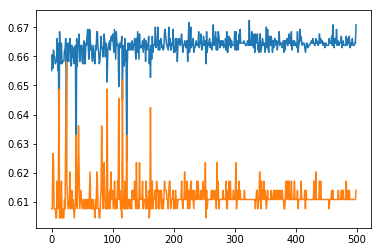

In [142]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.2, tol = 1e-4)

Weights used: {1.0: 1.55, 0.0: 2.86, 2.0: 226.57}
epoch=0 tscore=0.6551181102362205 vscore=0.6075949367088608
epoch=1 tscore=0.5149606299212598 vscore=0.5727848101265823
epoch=2 tscore=0.4952755905511811 vscore=0.5506329113924051
epoch=3 tscore=0.4937007874015748 vscore=0.5537974683544303
epoch=4 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=5 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=6 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=7 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=8 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=9 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=10 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=11 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=12 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=13 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=14 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=15 tscore=0.4937007874015748 vscore=0.5

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)



epoch=24 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=25 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=26 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=27 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=28 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=29 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=30 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=31 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=32 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=33 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=34 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=35 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=36 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=37 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=38 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=39 tscore=0.4937007874015748 vscore=0.5506329113924051
epoch=40 tscore=0.49370

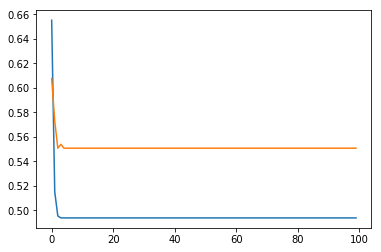

In [143]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(294, 13) (294,)
0.4489795918367347
[0.44897959 0.         0.        ]
1
(294, 13) (294,)
0.6394557823129252
[0.44897959 0.63945578 0.        ]
2
(294, 13) (294,)
0.5816326530612245
[0.44897959 0.63945578 0.58163265]
3


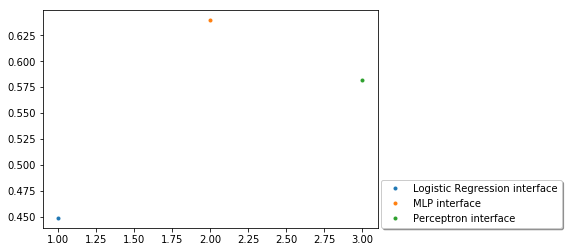

best is MLP interface with score 0.64


In [144]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

In [ ]:
num_age = my_MLP.predict(X,y, fill_up=True)

# Data Allowance

In [145]:
#most between 0 and 0.33, cut out outliers and rescale ?
df = df_clean.copy()

X = df[traffic_columns]
y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1386, test size 250


run=1 tscore=0.25 vscore=0.213287
run=2 tscore=0.353636 vscore=0.321678
run=3 tscore=0.353636 vscore=0.297203
run=4 tscore=0.347273 vscore=0.297203
run=5 tscore=0.351818 vscore=0.283217
run=6 tscore=0.359091 vscore=0.314685
run=7 tscore=0.356364 vscore=0.311189
run=8 tscore=0.363636 vscore=0.318182
run=9 tscore=0.358182 vscore=0.314685
run=10 tscore=0.354545 vscore=0.304196
run=11 tscore=0.35 vscore=0.300699
run=12 tscore=0.359091 vscore=0.318182
run=13 tscore=0.36 vscore=0.307692
run=14 tscore=0.358182 vscore=0.318182
run=15 tscore=0.359091 vscore=0.318182
run=16 tscore=0.361818 vscore=0.318182
run=17 tscore=0.355455 vscore=0.311189
run=18 tscore=0.357273 vscore=0.318182
run=19 tscore=0.36 vscore=0.318182
run=20 tscore=0.357273 vscore=0.314685
run=21 tscore=0.357273 vscore=0.318182
run=22 tscore=0.360909 vscore=0.318182
run=23 tscore=0.362727 vscore=0.318182
run=24 tscore=0.363636 vscore=0.318182
run=25 tscore=0.358182 vscore=0.318182
run=26 tscore=0.357273 vscore=0.318182
run=27 tsco

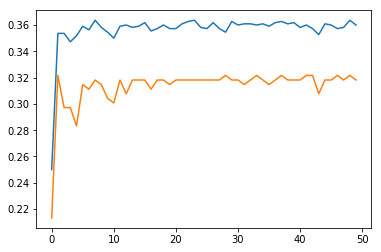

In [146]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=2.370385645326937 tscore=0.15 vscore=0.16783216783216784
epoch=1 loss=2.349888652424017 tscore=0.25363636363636366 vscore=0.26223776223776224
epoch=2 loss=2.329880350415014 tscore=0.29 vscore=0.2727272727272727
epoch=3 loss=2.310485482814401 tscore=0.3145454545454546 vscore=0.28321678321678323
epoch=4 loss=2.290883127698784 tscore=0.33636363636363636 vscore=0.3041958041958042
epoch=5 loss=2.2720939373077953 tscore=0.3490909090909091 vscore=0.32167832167832167
epoch=6 loss=2.2530638734778683 tscore=0.3490909090909091 vscore=0.32167832167832167
epoch=7 loss=2.2345961032785406 tscore=0.3490909090909091 vscore=0.32167832167832167
epoch=8 loss=2.215645337889893 tscore=0.3490909090909091 vscore=0.32167832167832167
epoch=9 loss=2.197292148574413 tscore=0.3490909090909091 vscore=0.32167832167832167
epoch=10 loss=2.178687481394685 tscore=0.3490909090909091 vscore=0.32167832167832167
epoch=11 loss=2.160049990888438 tscore=0.3490909090909091 vscore=0.32167832167832167
epoch=12 loss=2

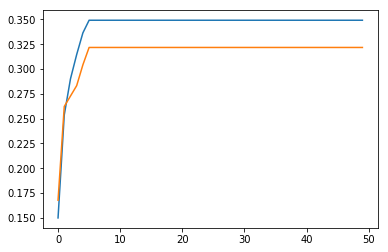

In [147]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (400,), batch_size = 100, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.05, tol = 1e-4)

(250, 13) (250,)
0.412
[0.412 0.   ]
1
(250, 13) (250,)
0.384
[0.412 0.384]
2


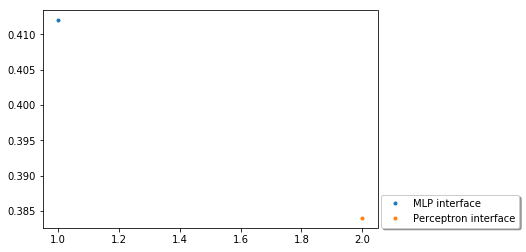

best is MLP interface with score 0.41


In [148]:
test_sup(*data.get_valid(), my_MLP, my_perc)

In [ ]:
data_all = my_MLP.predict(X,y, fill_up=True)

# Monthly Data Traffic

In [120]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['MonthlyDataTraffic'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1620, test size 297


Weights used: {'0.2': 92.0, '0.0': 1023.0, '0.1': 475.0, '0.5': 3.0, '0.3': 14.0, '0.4': 9.0, '1.0': 2.0, '0.9': 1.0, '0.7': 1.0}
run=1 tscore=0.119938 vscore=0.0803571
run=2 tscore=0.391745 vscore=0.383929
run=3 tscore=0.387072 vscore=0.345238
run=4 tscore=0.412773 vscore=0.407738
run=5 tscore=0.390187 vscore=0.366071
run=6 tscore=0.407321 vscore=0.366071
run=7 tscore=0.422118 vscore=0.410714
run=8 tscore=0.383956 vscore=0.357143
run=9 tscore=0.426012 vscore=0.425595
run=10 tscore=0.428349 vscore=0.425595
run=11 tscore=0.419003 vscore=0.425595
run=12 tscore=0.428349 vscore=0.416667
run=13 tscore=0.419782 vscore=0.416667
run=14 tscore=0.408879 vscore=0.404762
run=15 tscore=0.418224 vscore=0.410714
run=16 tscore=0.425234 vscore=0.422619
run=17 tscore=0.428349 vscore=0.431548
run=18 tscore=0.422118 vscore=0.428571
run=19 tscore=0.429128 vscore=0.425595
run=20 tscore=0.355919 vscore=0.35119
run=21 tscore=0.422897 vscore=0.4375
run=22 tscore=0.425234 vscore=0.431548
run=23 tscore=0.434579 

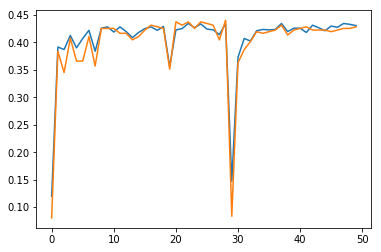

In [121]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.291906380475136 tscore=0.6246105919003115 vscore=0.6577380952380952
epoch=1 loss=0.9491170926026508 tscore=0.6246105919003115 vscore=0.6607142857142857
epoch=2 loss=0.9053933713330712 tscore=0.6253894080996885 vscore=0.6636904761904762
epoch=3 loss=0.878877248688663 tscore=0.6246105919003115 vscore=0.6726190476190477
epoch=4 loss=0.8737609898732962 tscore=0.6246105919003115 vscore=0.6666666666666666
epoch=5 loss=0.8658250308985755 tscore=0.6269470404984424 vscore=0.6547619047619048
epoch=6 loss=0.8646829868106635 tscore=0.6253894080996885 vscore=0.6666666666666666
epoch=7 loss=0.8600080742413007 tscore=0.6269470404984424 vscore=0.6607142857142857
epoch=8 loss=0.8548309652157281 tscore=0.6207165109034268 vscore=0.6726190476190477


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=9 loss=0.8615698249100334 tscore=0.6347352024922118 vscore=0.6636904761904762
epoch=10 loss=0.8539444580038611 tscore=0.6285046728971962 vscore=0.6875
epoch=11 loss=0.8496183657872411 tscore=0.6261682242990654 vscore=0.6577380952380952
epoch=12 loss=0.8461685339484952 tscore=0.6277258566978193 vscore=0.6577380952380952
epoch=13 loss=0.845793532456131 tscore=0.631619937694704 vscore=0.6577380952380952
epoch=14 loss=0.8447276840074347 tscore=0.6300623052959502 vscore=0.6815476190476191
epoch=15 loss=0.8459106701978685 tscore=0.6261682242990654 vscore=0.6577380952380952
epoch=16 loss=0.8489830120254702 tscore=0.631619937694704 vscore=0.6696428571428571
epoch=17 loss=0.8500969950864217 tscore=0.6285046728971962 vscore=0.6547619047619048
epoch=18 loss=0.840332201240167 tscore=0.6277258566978193 vscore=0.6607142857142857
epoch=19 loss=0.8365006541272673 tscore=0.6355140186915887 vscore=0.6607142857142857
epoch=20 loss=0.8409282202063438 tscore=0.6401869158878505 vscore=0.65773809523809

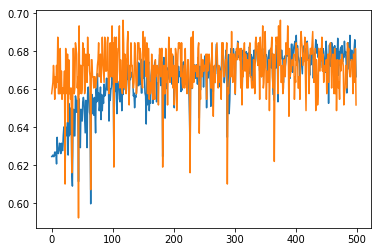

In [122]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(297, 13) (297,)
0.6902356902356902
[0.69023569 0.        ]
1
(297, 13) (297,)
0.4478114478114478
[0.69023569 0.44781145]
2


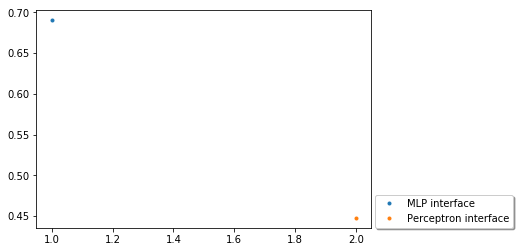

best is MLP interface with score 0.69


In [123]:
test_sup(*data.get_valid(), my_MLP, my_perc)

In [ ]:
data_traffic = my_MLP.predict(X,y, fill_up=True)

# Data ARPU

In [124]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['DataArpu'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1270, test size 223


run=1 tscore=0.277445 vscore=0.261194
run=2 tscore=0.452096 vscore=0.402985
run=3 tscore=0.456088 vscore=0.395522
run=4 tscore=0.452096 vscore=0.402985
run=5 tscore=0.453094 vscore=0.399254
run=6 tscore=0.456088 vscore=0.399254
run=7 tscore=0.456088 vscore=0.391791
run=8 tscore=0.456088 vscore=0.380597
run=9 tscore=0.45509 vscore=0.402985
run=10 tscore=0.458084 vscore=0.395522
run=11 tscore=0.453094 vscore=0.38806
run=12 tscore=0.456088 vscore=0.395522
run=13 tscore=0.45509 vscore=0.395522
run=14 tscore=0.45509 vscore=0.38806
run=15 tscore=0.456088 vscore=0.395522
run=16 tscore=0.462076 vscore=0.395522
run=17 tscore=0.456088 vscore=0.395522
run=18 tscore=0.451098 vscore=0.384328
run=19 tscore=0.457086 vscore=0.402985
run=20 tscore=0.457086 vscore=0.399254
run=21 tscore=0.457086 vscore=0.399254
run=22 tscore=0.452096 vscore=0.38806
run=23 tscore=0.459082 vscore=0.402985
run=24 tscore=0.458084 vscore=0.391791
run=25 tscore=0.456088 vscore=0.395522
run=26 tscore=0.458084 vscore=0.402985
r

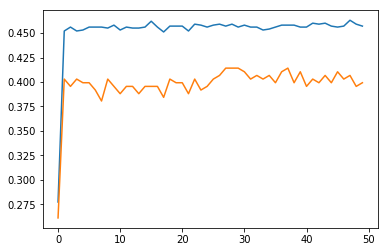

In [125]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.744322288530698 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=1 loss=1.3883646458960324 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=2 loss=1.3706931839943122 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=3 loss=1.3667316193682584 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=4 loss=1.3584575800340433 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=5 loss=1.3525671371353647 tscore=0.4540918163672655 vscore=0.39925373134328357
epoch=6 loss=1.3597388879988055 tscore=0.4491017964071856 vscore=0.41044776119402987
epoch=7 loss=1.3609369790191619 tscore=0.4481037924151697 vscore=0.4141791044776119
epoch=8 loss=1.3471079733758398 tscore=0.46407185628742514 vscore=0.3843283582089552
epoch=9 loss=1.3439641445611932 tscore=0.4471057884231537 vscore=0.4141791044776119
epoch=10 loss=1.3628362340382887 tscore=0.4540918163672655 vscore=0.40671641791044777
epoch=11 loss=1.345592010120741 tscore=0.4500998003992016 vscore=0.4104477611

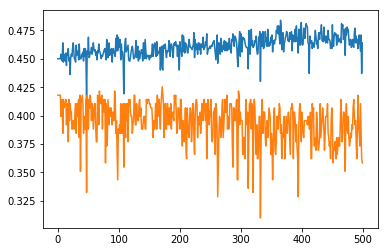

In [126]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(223, 13) (223,)
0.4663677130044843
[0.46636771 0.        ]
1
(223, 13) (223,)
0.5112107623318386
[0.46636771 0.51121076]
2


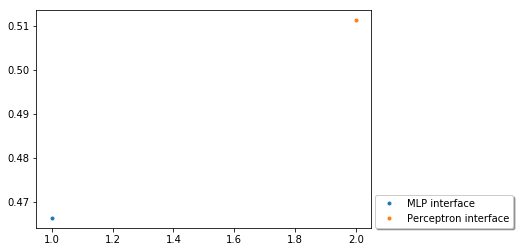

best is Perceptron interface with score 0.51


In [127]:
test_sup(*data.get_valid(), my_MLP, my_perc)

In [ ]:
data_arpu = my_MLP.predict(X,y, fill_up=True)

# Monthly Voice Traffic Count

In [128]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['MonthlyVoiceTrafficCount'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1614, test size 303


run=1 tscore=0.336463 vscore=0.330357
run=2 tscore=0.43662 vscore=0.369048
run=3 tscore=0.43975 vscore=0.372024
run=4 tscore=0.438185 vscore=0.366071
run=5 tscore=0.438967 vscore=0.366071
run=6 tscore=0.456182 vscore=0.372024
run=7 tscore=0.441315 vscore=0.357143
run=8 tscore=0.437402 vscore=0.360119
run=9 tscore=0.449922 vscore=0.383929
run=10 tscore=0.441315 vscore=0.357143
run=11 tscore=0.460876 vscore=0.372024
run=12 tscore=0.466354 vscore=0.377976
run=13 tscore=0.444444 vscore=0.35119
run=14 tscore=0.467136 vscore=0.375
run=15 tscore=0.43975 vscore=0.360119
run=16 tscore=0.449922 vscore=0.363095
run=17 tscore=0.444444 vscore=0.35119
run=18 tscore=0.443662 vscore=0.363095
run=19 tscore=0.449922 vscore=0.363095
run=20 tscore=0.443662 vscore=0.363095
run=21 tscore=0.468701 vscore=0.375
run=22 tscore=0.456182 vscore=0.369048
run=23 tscore=0.444444 vscore=0.360119
run=24 tscore=0.447574 vscore=0.360119
run=25 tscore=0.463224 vscore=0.377976
run=26 tscore=0.438967 vscore=0.345238
run=27

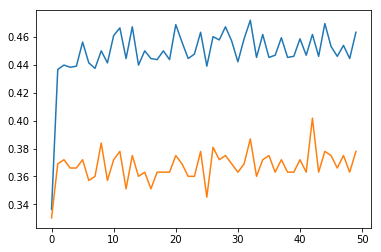

In [129]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.5652085804950153 tscore=0.486697965571205 vscore=0.4375
epoch=1 loss=1.3144318718163228 tscore=0.4694835680751174 vscore=0.42857142857142855
epoch=2 loss=1.2901005472940703 tscore=0.4702660406885759 vscore=0.41964285714285715
epoch=3 loss=1.2799780571294093 tscore=0.48826291079812206 vscore=0.42857142857142855
epoch=4 loss=1.272048348221048 tscore=0.47417840375586856 vscore=0.40773809523809523
epoch=5 loss=1.2648469490863463 tscore=0.48043818466353677 vscore=0.4166666666666667
epoch=6 loss=1.2675127028756548 tscore=0.48826291079812206 vscore=0.43154761904761907
epoch=7 loss=1.2618387378614926 tscore=0.4921752738654147 vscore=0.42857142857142855
epoch=8 loss=1.2479024812661381 tscore=0.48826291079812206 vscore=0.4226190476190476
epoch=9 loss=1.2459981886839435 tscore=0.49139280125195617 vscore=0.4226190476190476
epoch=10 loss=1.2433008580669755 tscore=0.48826291079812206 vscore=0.4255952380952381
epoch=11 loss=1.2459351754117998 tscore=0.4921752738654147 vscore=0.42559523

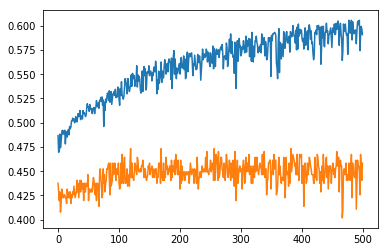

In [130]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(303, 13) (303,)
0.44884488448844884
[0.44884488 0.        ]
1
(303, 13) (303,)
0.47854785478547857
[0.44884488 0.47854785]
2


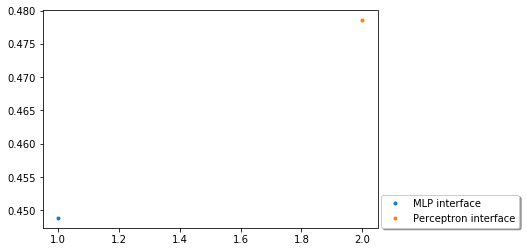

best is Perceptron interface with score 0.48


In [131]:
test_sup(*data.get_valid(), my_MLP, my_perc)

In [ ]:
voice_traffic_c = my_MLP.predict(X,y, fill_up=True)